In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import create_engine, inspect

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first().date

session.close()

print(most_recent_date)

2017-08-23


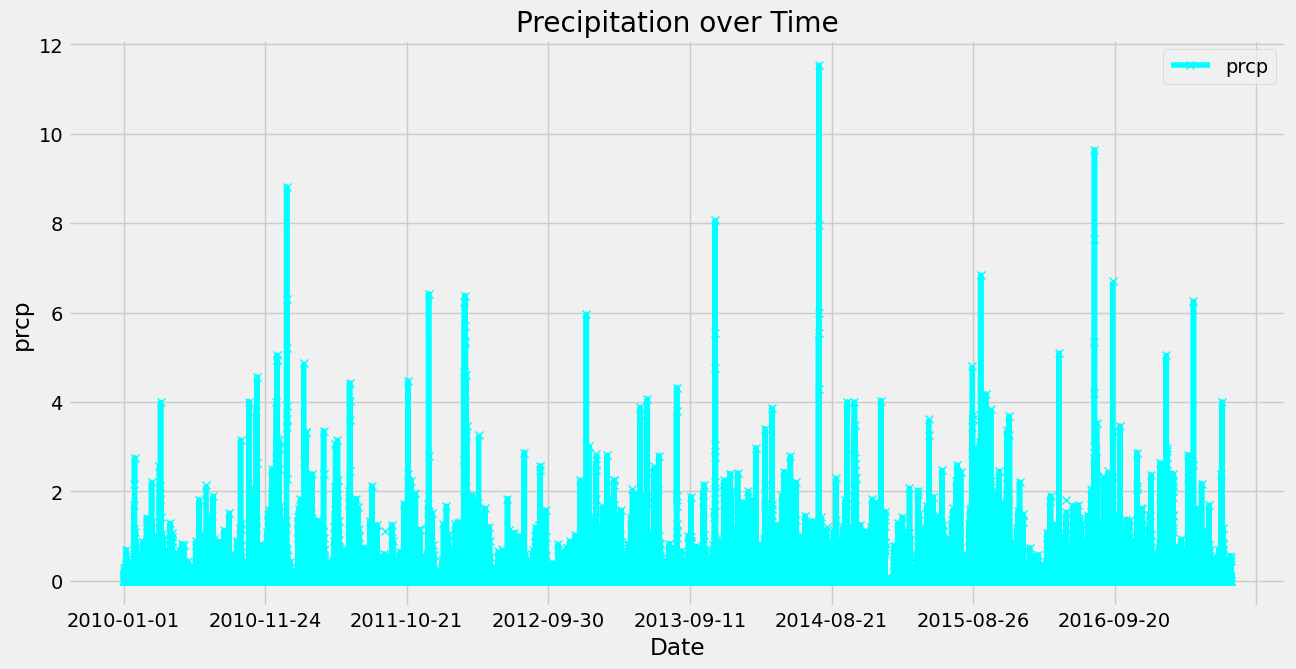

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_year_rain = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()

# Calculate the date one year from the last date in data set.
one_year =  dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data_and_precipitation = session.query(Measurement.date, Measurement.prcp).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
dp_df = pd.DataFrame(data_and_precipitation, columns=['date', 'prcp'])


# Sort the dataframe by date
dp_df = dp_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
dp_df.plot(x='date', y='prcp', kind='line', color='cyan', marker='x', linestyle='-', figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel('prcp')
plt.title('Precipitation over Time')
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
dp_df.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(Station).count()
stations

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps_stats= session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()
temps_stats

[(54.0, 85.0, 71.66378066378067)]

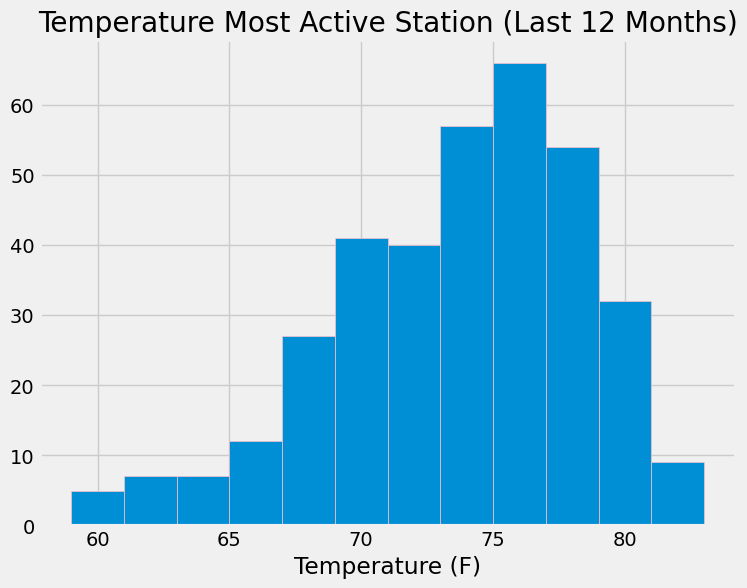

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_last_date = session.query(func.max(Measurement.date)).filter(Measurement.station == 'USC00519281').scalar()
# active_last_date
last_year = dt.date(2017, 8, 18) - dt.timedelta(days=365)
# last_year
one_year_active = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= last_year).all()

df = pd.DataFrame(one_year_active, columns=['tobs'])

plt.figure(figsize=(8, 6))
plt.hist(df['tobs'], bins=12, edgecolor='pink')
plt.title(f'Temperature Most Active Station (Last 12 Months)')
plt.xlabel('Temperature (F)')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()